In [0]:
!pip3 uninstall pytorch-hrvvi-ext -y
!pip3 install -U --no-cache-dir pytorch-hrvvi-ext


In [0]:
!pip3 uninstall pytorch-hrvvi-ext -y
!pip3 install -U git+https://github.com/sbl1996/pytorch-hrvvi-ext.git


In [1]:
import sys
import os

import torch
import hutil
import matplotlib.pyplot as plt
print(hutil.__version__)

1.4.14


In [0]:
%load_ext autoreload
%autoreload 2

In [3]:
gdrive = "/gdrive"
from google.colab import drive
drive.mount(gdrive, force_remount=True)
mydrive = os.path.join(gdrive, "My Drive")
!ls /gdrive/My\ Drive

def gpath(p):
    return os.path.join(mydrive, p)

Mounted at /gdrive
'Colab Notebooks'   eng-fra.pt	 images   repo	   weixin.pkl
 datasets	    fonts	 models   result


In [4]:
import os
import heapq
import random

import numpy as np
from PIL import Image
from toolz import curry

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import LambdaLR, MultiStepLR
from torch.utils.data import DataLoader, ConcatDataset

from torchvision.models import resnet18

from hutil import cuda, one_hot
from hutil.data import train_test_split, Fullset
from hutil.train import init_weights, Trainer
from hutil.datasets.voc import VOCDetection, DETECTION_CATEGORIES
from hutil.train.metrics import TrainLoss, MeanAveragePrecision
from hutil.ext.summary import summary
from hutil.detection import transform_bbox, box_collate_fn, draw_bboxes, BBox, non_max_suppression, iou_1m, transform_bboxes
from hutil.transforms.detection import Compose, Resize, ToTensor, ToPercentCoords, CenterCrop, RandomHorizontalFlip
from hutil.inference import freeze


In [0]:
import math
import heapq
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

from hutil import one_hot
from hutil.detection import BBox, transform_bboxes, transform_bbox, iou_1m, non_max_suppression

def inverse_sigmoid(x):
    return math.log(x / (1-x))

def compute_default_boxes(lx, ly, ars):
    default_boxes = torch.zeros(lx, ly, len(ars), 4)
    default_boxes[:, :, :, 0] = (torch.arange(
        lx, dtype=torch.float).view(lx, 1, 1).expand(lx, ly, len(ars)) + 0.5) / lx
    default_boxes[:, :, :, 1] = (torch.arange(
        ly, dtype=torch.float).view(1, ly, 1).expand(lx, ly, len(ars)) + 0.5) / ly
    default_boxes[:, :, :, 2] = ars.sqrt() / lx
    default_boxes[:, :, :, 3] = (1 / ars).sqrt() / ly
    return default_boxes


def compute_loc_target(gt_box, default_boxes):
    box_txty = (gt_box[:2] - default_boxes[..., :2]) \
        / default_boxes[..., 2:]
    box_twth = torch.log(gt_box[2:] / default_boxes[..., 2:])
    return torch.cat((box_txty, box_twth), dim=-1)


class RetinaTransform:

    def __init__(self, default_boxes, num_classes, label_field="category_id", bbox_field="bbox"):
        self.default_boxes = default_boxes
        self.num_classes = num_classes
        self.label_field = label_field
        self.bbox_field = bbox_field

    def __call__(self, img, anns):
        num_feature_maps = len(self.default_boxes)
        loc_target = []
        cls_target = []
        default_boxes = []
        for i in range(num_feature_maps):
            d_boxes = self.default_boxes[i].view(-1, 4)
            default_boxes.append(d_boxes)
            num_anchors = d_boxes.size(0)
            loc_target.append(torch.zeros(
                num_anchors, 4))
            cls_target.append(torch.full(
                (num_anchors,), self.num_classes, dtype=torch.long))

        for ann in anns:
            label = ann[self.label_field]
            x, y, w, h = ann[self.bbox_field]
            cx = x + w / 2
            cy = y + h / 2
            bbox = torch.tensor([cx, cy, w, h])

            max_ious = []
            for d_boxes, loc_t, cls_t in zip(default_boxes, loc_target, cls_target):

                ious = iou_1m(bbox, d_boxes, format=BBox.XYWH)
                max_ious.append(ious.max(dim=0))

                iou_mask = ious > 0.5
                if iou_mask.sum() != 0:
                    cls_t[iou_mask] = label
                    loc_t[iou_mask] = compute_loc_target(
                        bbox, d_boxes[iou_mask])
            i, (max_iou, ind) = max(
                enumerate(max_ious), key=lambda x: x[1][0])
            loc_target[i][ind] = compute_loc_target(
                bbox, default_boxes[i][ind]
            )
            cls_target[i][ind] = label
        return img, [loc_target, cls_target]


def focal_loss2(input, target, gamma, beta, reduction='mean'):
    target = target.unsqueeze(1)
    logit = gamma * input.gather(1, target) + beta
    input = input.scatter(1, target, logit)
    return F.cross_entropy(input, target.squeeze(1), reduction=reduction) / gamma



def binary_focal_loss2(input, target, gamma=2, beta=1, alpha=0.25, eps=1e-4, reduction='mean'):
    xt = gamma * input + beta * (2 * target - 1)
    eps = inverse_sigmoid(1-eps)
    xt = torch.clamp(xt, -eps, eps)
    return F.binary_cross_entropy_with_logits(
        xt, target,
        reduction=reduction,
        pos_weight=torch.tensor(alpha)) / gamma


class RetinaLoss(nn.Module):
    r"""
    Inputs: loc_preds, cls_preds, loc_target, cls_target
        cls_preds: sequence of (batch_size, #anchors, C)
        loc_preds: sequence of (batch_size, #anchors, 4)
        cls_target: sequence of (batch_size, #anchors, C)
        loc_target: sequence of (batch_size, #anchors, 4)
    """

    def __init__(self, num_classes, p=0.01, focal_loss=False, eps=1e-4):
        super().__init__()
        self.num_classes = num_classes
        self.p = p
        self.focal_loss = focal_loss
        self.eps = eps

    def forward(self, loc_preds, cls_preds, loc_target, cls_target):
        loc_loss = 0
        cls_loss = 0
        total_pos = 0
        for loc_p, cls_p, loc_t, cls_t in zip(loc_preds, cls_preds, loc_target, cls_target):
            pos = cls_t != self.num_classes
            num_pos = pos.sum().item()
            if num_pos == 0:
                continue
            loc_loss += F.smooth_l1_loss(
                loc_p[pos], loc_t[pos], reduction='sum')

            cls_t = one_hot(cls_t, self.num_classes + 1)[..., :-1]
            if self.focal_loss:
                cls_loss += binary_focal_loss2(
                    cls_p, cls_t, 2, 1, 0.25, eps=self.eps, reduction='sum')
            else:
                cls_loss += F.binary_cross_entropy_with_logits(
                    cls_p, cls_t, reduction='sum')

            total_pos += num_pos
        loss = (loc_loss + cls_loss) / total_pos
        if random.random() < self.p:
            print("loc: %.4f | cls: %.4f" %
                  (loc_loss.item() / total_pos, cls_loss.item() / total_pos))
        return loss



class RetinaInference:

    def __init__(self, width, height, default_boxes, num_classes,
                 conf_threshold=0.05, topk=10,
                 max_boxes=10, iou_threshold=0.45):
        self.width = width
        self.height = height
        self.default_boxes = default_boxes
        self.num_classes = num_classes
        self.conf_threshold = conf_threshold
        self.topk = topk
        self.max_boxes = max_boxes
        self.iou_threshold = iou_threshold

    def __call__(self, loc_preds, cls_preds):
        detections = []
        batch_size = cls_preds[0].size(0)
        for i in range(batch_size):
            boxes = []
            confs = []
            labels = []
            for loc_p, cls_p, d_boxes in zip(loc_preds, cls_preds, self.default_boxes):
                loc_p = loc_p[i]
                cls_p = cls_p[i]
                d_boxes = d_boxes.view(-1, 4)

                conf = torch.sigmoid_(cls_p)
                conf, label = torch.max(conf, dim=1)

                mask = conf > self.conf_threshold
                conf = conf[mask]
                label = label[mask]
                box = loc_p[mask]
                d_boxes = d_boxes[mask]
                if len(conf) > self.topk:
                    conf, indices = torch.topk(conf, self.topk)
                    label = label[indices]
                    box = box[indices]
                    d_boxes = d_boxes[indices]

                box[:, :2].mul_(d_boxes[:, 2:]).add_(d_boxes[:, :2])
                box[:, 2:].exp_().mul_(d_boxes[:, 2:])

                box[:, [0, 2]] *= self.width
                box[:, [1, 3]] *= self.height

                boxes.append(box)
                confs.append(conf)
                labels.append(label)

            boxes = torch.cat(boxes, dim=0)
            confs = torch.cat(confs, dim=0)
            labels = torch.cat(labels, dim=0)

            boxes = transform_bboxes(
                boxes, format=BBox.XYWH, to=BBox.LTRB, inplace=True)
            indices = non_max_suppression(
                boxes, confs, self.max_boxes, self.iou_threshold)
            dets = [
                BBox(
                    image_name=i,
                    class_id=labels[ind].item(),
                    box=boxes[ind].tolist(),
                    confidence=confs[ind].item(),
                    box_format=BBox.LTRB,
                ) for ind in indices
            ]
            detections += dets
        return detections


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def conv1x1(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1)


def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)


def _upsample_add(x, y):
    h, w = y.size()[2:]
    return F.interpolate(x, size=(h, w), mode='bilinear', align_corners=False) + y


def _make_head(f_channels, num_layers, out_channels):
    layers = []
    for i in range(num_layers):
        layers.append(conv3x3(f_channels, f_channels))
        layers.append(nn.ReLU(inplace=True))
    layers.append(conv3x3(f_channels, out_channels))
    return nn.Sequential(*layers)


class RetinaNet(nn.Module):

    def __init__(self, backbone, num_classes=10, num_anchors=3, f_channels=256):
        super().__init__()
        self.num_classes = num_classes
        self.conv1 = backbone.conv1
        self.bn1 = backbone.bn1
        self.relu = backbone.relu
        self.maxpool = backbone.maxpool

        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4

        self.conv5 = conv3x3(512, f_channels, stride=2)
        self.conv6 = nn.Sequential(
            nn.ReLU(inplace=True),
            conv3x3(f_channels, f_channels, stride=2)
        )

        self.lat1 = conv1x1(512, f_channels)
        self.lat2 = conv1x1(256, f_channels)
        self.lat3 = conv1x1(128, f_channels)

        self.top1 = conv3x3(f_channels, f_channels)
        self.top2 = conv3x3(f_channels, f_channels)
        
        for m in [self.conv5, self.conv6, self.lat1, self.lat2, self.lat3, self.top1, self.top2]:
            m.apply(init_weights(nonlinearity='relu'))

        self.loc_head = _make_head(f_channels, 4, num_anchors * 4)
        self.cls_head = _make_head(f_channels, 4, num_anchors * num_classes)
        
        for m in [self.loc_head, self.cls_head]:
            m.apply(self._init_new_layers)
        self.cls_head[-1].apply(self._init_final_cls_layer)
        
    
    def _init_new_layers(self, m):
        name = type(m).__name__
        if name.find("Linear") != -1 or name.find("Conv") != -1:
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
    
    def _init_final_cls_layer(self, m, p=0.01):
        name = type(m).__name__
        if name.find("Linear") != -1 or name.find("Conv") != -1:
            nn.init.constant_(m.bias, -np.log((1 - p) / p))


    def forward(self, x):
        b = x.size(0)
        c1 = self.conv1(x)
        c1 = self.bn1(c1)
        c1 = self.relu(c1)
        c2 = self.maxpool(c1)

        c2 = self.layer1(c2)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        p6 = self.conv5(c5)
        p7 = self.conv6(p6)

        p5 = self.lat1(c5)
        p4 = _upsample_add(p5, self.lat2(c4))
        p4 = self.top1(p4)
        p3 = _upsample_add(p4, self.lat3(c3))
        p3 = self.top2(p3)

        fs = [p3, p4, p5, p6, p7]

        loc_preds = []
        cls_preds = []
        for f in fs:
            loc_pred = self.loc_head(f)
            loc_pred = loc_pred.permute(
                0, 3, 2, 1).contiguous().view(b, -1, 4)
            loc_preds.append(loc_pred)

            cls_pred = self.cls_head(f)
            cls_pred = cls_pred.permute(
                0, 3, 2, 1).contiguous().view(b, -1, self.num_classes)
            cls_preds.append(cls_pred)

        return loc_preds, cls_preds


In [0]:


WIDTH = 400
HEIGHT = 400
LOCATIONS = [
    (50, 50),
    (25, 25),
    (13, 13),
    (7, 7),
    (4, 4),
]
ASPECT_RATIOS = torch.tensor([
    1, 2, 3, 1/2, 1/3,
])
DEFAULT_BOXES = [
    compute_default_boxes(lx, ly, ASPECT_RATIOS)
    for lx, ly in LOCATIONS
]

NUM_CLASSES = 20

In [8]:

train_transform = Compose([
    RandomHorizontalFlip(),
    Resize(HEIGHT),
    CenterCrop(HEIGHT),
    ToPercentCoords(),
    ToTensor(),
    RetinaTransform(DEFAULT_BOXES, NUM_CLASSES)
])

test_transform = Compose([
    Resize(HEIGHT),
    CenterCrop(HEIGHT),
    ToTensor(),
])

data_home = "./VOC"
# ds1 = VOCDetection(data_home, year='2007', image_set='trainval', download=True)
# ds2 = VOCDetection(data_home, year='2012', image_set='trainval', download=True)
# ds = ConcatDataset([ds1, ds2])
ds = VOCDetection(data_home, year='2012', image_set='trainval', download=True)
# rest, ds = train_test_split(
#     ds, test_ratio=0.01
# )
# ds_train = Fullset(ds, train_transform)
# ds_val = Fullset(ds, test_transform)

ds_train, ds_val = train_test_split(
    ds, test_ratio=0.05,
    transform=train_transform,
    test_transform=test_transform)


Dataset found. Skip download or extract


In [0]:

backbone = resnet18(pretrained=True)
del backbone.fc
freeze(backbone)

net = RetinaNet(backbone, NUM_CLASSES, len(ASPECT_RATIOS), f_channels=256)
criterion = RetinaLoss(NUM_CLASSES, p=0.2, focal_loss=True, eps=1e-6)
# optimizer = SGD(filter(lambda x: x.requires_grad,
#                         net.parameters()), lr=0.01, momentum=0.9, dampening=0.9, weight_decay=1e-4)
optimizer = Adam(filter(lambda x: x.requires_grad,
                        net.parameters()), lr=1e-4, weight_decay=1e-4)
lr_scheduler = MultiStepLR(optimizer, [90, 120], gamma=0.1)


metrics = {
    'loss': TrainLoss(),
}
inference = RetinaInference(
    WIDTH, HEIGHT, cuda(DEFAULT_BOXES), NUM_CLASSES,
    topk=100, max_boxes=30)
test_metrics = {
    'mAP': MeanAveragePrecision(inference)
}

trainer = Trainer(net, criterion, optimizer, lr_scheduler,
                  metrics=metrics, evaluate_metrics=test_metrics,
                  save_path=gpath("models"), name="RetinaNet-VOC")


In [0]:
trainer.load_state_dict(torch.load(gpath("models/RetinaNet-VOC_trainer_54_Adam.pth")))

In [0]:
summary(net, (3,HEIGHT, WIDTH))

In [0]:
train_loader = DataLoader(
    ds_train, batch_size=16, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(
    ds_val, batch_size=64, collate_fn=box_collate_fn)


In [0]:
hist = trainer.fit(train_loader, 10, save_per_epochs=1)
plot_history(hist)

Epoch 55/64
loc: 0.1150 | cls: 0.5883
loc: 0.0826 | cls: 0.4396
loc: 0.1860 | cls: 0.6240
loc: 0.1460 | cls: 0.3483
loc: 0.0930 | cls: 0.6655
loc: 0.7235 | cls: 0.4563
loc: 2.1771 | cls: 0.5396
loc: 0.8585 | cls: 0.2970
loc: 0.0810 | cls: 0.1865
loc: 0.5919 | cls: 0.4296
loc: 5.0167 | cls: 0.4846
loc: 1.5325 | cls: 0.4101
loc: 0.0904 | cls: 0.4541
loc: 0.1117 | cls: 0.4226
loc: 0.0640 | cls: 0.2925
loc: 0.4248 | cls: 0.5290
loc: 0.1062 | cls: 0.3288
loc: 0.2893 | cls: 0.4266
loc: 0.1213 | cls: 0.3055
loc: 1.2775 | cls: 0.4259
loc: 2.5098 | cls: 0.2994
loc: 0.1808 | cls: 0.4951
loc: 0.0829 | cls: 0.2211
loc: 0.1966 | cls: 0.3474
loc: 5.3814 | cls: 0.4026
loc: 0.1857 | cls: 0.6571
loc: 0.1430 | cls: 0.3463
loc: 0.2837 | cls: 0.5705
loc: 3.2090 | cls: 0.5101
loc: 0.1143 | cls: 0.3567
loc: 0.0794 | cls: 0.3132
loc: 0.1719 | cls: 0.4684
loc: 0.2797 | cls: 0.3853
loc: 0.7417 | cls: 0.4638
loc: 0.4752 | cls: 0.4667
loc: 2.4062 | cls: 0.4482
loc: 0.1975 | cls: 0.2800
loc: 0.1343 | cls: 0.4028


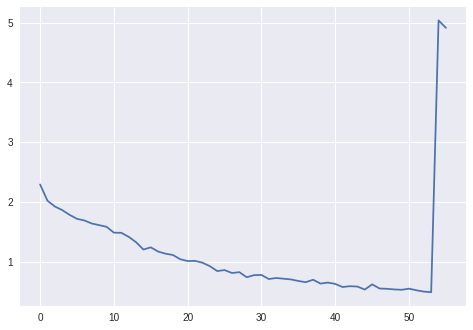

In [19]:
plt.plot(trainer.metric_history['loss'])

In [0]:
def plot_history(hist):
    for k, v in hist.items():
        fig, ax = plt.subplots()
        ax.plot(v)
        ax.set_title(k)

In [20]:
test_metrics['mAP'].predict.max_boxes = 30
%time trainer.evaluate(val_loader)

CPU times: user 27.2 s, sys: 6.45 s, total: 33.7 s
Wall time: 33.7 s


{'mAP': 0.4481180311090097}